In [1]:
# run_with_new_generator_star.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Typography / plot style (legends are mechanism names only)
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30

# --- NEW: data utilities (star model) ---
from data_utils_newest import (
    gen_star_from_x1,       # <-- star/hub generator
    get_true_frequencies,
    gen_progressive,

)
def list_all_correlations(df):
    """
    Return a DataFrame listing all pairwise Pearson correlations:
      Xi, Xj, correlation
    for all i < j.
    """
    cols = list(df.columns)
    results = []

    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            a, b = cols[i], cols[j]
            corr = df[a].astype(float).corr(df[b].astype(float))
            results.append((a, b, corr))

    return pd.DataFrame(results, columns=["Attr1", "Attr2", "PearsonCorr"])

# --- baselines ---
from metrics import compute_mse
from spl import random_split_perturb, random_split_estimate
from rs_fd import rs_fd_perturb, rs_fd_estimate
from rs_rfd import rs_rfd_perturb, rs_rfd_estimate

from corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)

# ---------------- helpers ----------------

def pearson_corr_matrix(df):
    """
    Compute full pairwise Pearson correlation matrix
    across all attributes X1..Xd.
    """
    return df.astype(float).corr()

def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}

def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }

# ---------------- one-shot runner ----------------
def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # SPL
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # RS+FD
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # RS+RFD (two-phase)
    est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)
    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}
    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_rsrfd, priors_2p, epsilon)
    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # Corr-RR
    if use_corr_rr:
        est_I, df_B, doms_stable = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)
        common_domain = doms_stable[cols[0]]
        p_y_table = _build_p_y_table_minimal(est_I, epsilon, n2, common_domain, cols)
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out

def sweep_all(
    n=10000,
    epsilons=(0.2, 0.4, 0.6, 0.8, 1.0),
    R=50,
    corr=0.9,                 # global rho: every Xj (j>=2) correlates to X1
    d=4,                      # total attributes generated
    domain=None,
    x1_marginal=None,         # marginal p for X1 (and X1 only)
    q_marginal=None,          # None => uniform for non-copy branch
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    """
    Fixed-dataset sweep:
      - Generate ONE synthetic dataset using the star model.
      - Compute and print its Pearson correlation matrix.
      - Run all mechanisms multiple times on the SAME dataset.
    """

    # default settings
    if domain is None:
        domain = [0, 1]

    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(epsilons)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    # =====================================================
    # 1) Generate ONE fixed dataset (critical change)
    # =====================================================
    df = gen_star_from_x1(
        n=n,
        domain=domain,
        d=d,
        x1_marginal=x1_marginal,
        rho=corr,
        q_marginal=q_marginal,
        seed=seed,    # ensures reproducibility
    )

    # =====================================================
    # 2) Compute and print true Pearson correlation matrix
    # =====================================================
    
    list_co = list_all_correlations(df)
    corr_mat = pearson_corr_matrix(df)
    dom = len(domain)
    # print("\n==============================================")
    # print(" Pearson Correlation Matrix (Progressive Data) ")
    # print("==============================================\n")
    # print(corr_mat)
    # print("\n")
    print("\n==============================================")
    print(" Pearson Correlation list of Synthetic Data ")
    print("==============================================\n")
    print(list_co)
    print("\n")
    print(dom)
    print(x1_marginal)
    # Save if directory is provided
    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        corr_mat.to_csv(os.path.join(csv_dir, "pearson_corr_matrix.csv"))

    # =====================================================
    # 3) Main sweep across epsilons
    # =====================================================
    for run in range(R):
        for j, eps in enumerate(epsilons):
            res = run_all_once(
                df,
                eps,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # =====================================================
    # 4) Plotting
    # =====================================================
    plt.figure(figsize=(10, 8))
    plt.plot(epsilons, means["SPL"],         '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(epsilons, means["RS+FD"],       '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(epsilons, means["RS+RFD"],      '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(epsilons, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE',  fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    # Save plot
    def _fmt(x): return f"{x:g}"
    base = f"mseVSepsilon_{d}attr_{len(domain)}domain_n_{n}_rho_{_fmt(corr)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    # Save MSE results
    if csv_dir:
        df_out = pd.DataFrame({"epsilon": list(epsilons)})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    return means


def sweep_all_progressive(
    n=10000,
    epsilons=(0.2, 0.4, 0.6, 0.8, 1.0),
    R=50,
    rho=0.9,                 # global copy probability
    d=4,                     # total attributes
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    """
    Fixed-dataset sweep for the PROGRESSIVE dependency model:
      - Generate ONE synthetic dataset using gen_progressive().
      - Print its Pearson correlation matrix.
      - Run all mechanisms multiple times on that SAME dataset.
    """

    # -------------------------------
    # defaults
    # -------------------------------
    if domain is None:
        domain = [0, 1]

    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(epsilons)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    # =========================================================
    # 1) Generate ONE fixed progressive dataset
    # =========================================================
    df = gen_progressive(
        n=n,
        domain=domain,
        d=d,
        x1_marginal=x1_marginal,
        rho=rho,
        q_marginal=q_marginal,
        seed=seed
    )
    # =========================================================
    # 2) Compute & print true Pearson correlation matrix
    # =========================================================
    list_co = list_all_correlations(df)
    corr_mat = pearson_corr_matrix(df)
    dom = len(domain)
    # print("\n==============================================")
    # print(" Pearson Correlation Matrix (Progressive Data) ")
    # print("==============================================\n")
    # print(corr_mat)
    # print("\n")
    print("\n==============================================")
    print(" Pearson Correlation list of Synthetic Data ")
    print("==============================================\n")
    print(list_co)
    print("\n")
    print(dom)
    print(x1_marginal)
    

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        corr_mat.to_csv(os.path.join(csv_dir, "pearson_corr_matrix_progressive.csv"))

    # =========================================================
    # 3) Sweep all mechanisms on the SAME dataset
    # =========================================================
    for run in range(R):
        for j, eps in enumerate(epsilons):
            res = run_all_once(
                df,
                eps,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # =========================================================
    # 4) Plotting
    # =========================================================
    plt.figure(figsize=(10, 8))
    plt.plot(epsilons, means["SPL"],         '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(epsilons, means["RS+FD"],       '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(epsilons, means["RS+RFD"],      '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(epsilons, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE',  fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    base = f"mseVSepsilon_progressive_{d}attr_{len(domain)}domain_n_{n}_rho_{rho}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        df_out = pd.DataFrame({"epsilon": list(epsilons)})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    return means


In [2]:
# PRINT_DEBUG_CORR = False

# def get_corr_pairs(df):
#     cols = list(df.columns)
#     C = df.astype(float).corr()
#     out = []
#     for i in range(len(cols)):
#         for j in range(i+1, len(cols)):
#             a, b = cols[i], cols[j]
#             v = C.loc[a,b]
#             v = float(v) if v == v else float("nan")
#             out.append((a,b,v))
#     return out

# def print_corr(df, name):
#     print(f"\n========== {name} Correlations ==========")
#     for a,b,v in get_corr_pairs(df):
#         print(f"({a},{b}): {v:.4f}")
#     print("========================================\n")


In [3]:
# ############################################################
# #   COMMON HELPERS
# ############################################################

# def print_corr_info(df, label):
#     """Pretty print correlation info for debugging."""
#     print(f"\n===== {label} Correlation Info =====")
#     corr_df = df.astype(float).corr()
#     print(corr_df)
#     print("====================================\n")


# ############################################################
# #   ✅ OPTIMIZED STAR MODEL PHASE-1 SWEEP
# ############################################################

# def sweep_vs_phase1_star(
#     phase1_pcts=(10, 20, 30, 40, 50),
#     epsilon=0.6,
#     n=10000,
#     R=50,
#     rho=0.9,
#     d=4,
#     domain=None,
#     x1_marginal=None,
#     q_marginal=None,
#     seed=None,
#     use_corr_rr=True,
#     plot_dir=None,
#     csv_dir=None,
#     print_debug=False,
# ):
#     """Phase-1 sweep for STAR model with SPL/RSFD run ONCE."""

#     if domain is None:
#         domain = [0, 1]
#     if x1_marginal is None:
#         x1_marginal = {v: 1.0 / len(domain) for v in domain}

#     keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
#     means = {k: np.zeros(len(phase1_pcts)) for k in keys}

#     if seed is not None:
#         np.random.seed(seed)

#     # -----------------------------------------------------------
#     # ✅ Generate ONE fixed STAR dataset
#     # -----------------------------------------------------------
#     df = gen_star_from_x1(
#         n=n,
#         domain=domain,
#         d=d,
#         x1_marginal=x1_marginal,
#         rho=rho,
#         q_marginal=q_marginal,
#         seed=seed,
#     )

#     if print_debug:
#         print_corr_info(df, "FULL STAR DATASET")

#     true_freqs = get_true_frequencies(df)

#     ############################################################
#     # ✅ Compute SPL & RS+FD ONCE (horizontal straight lines)
#     ############################################################
#     spl_vals = []
#     rsfd_vals = []

#     for run in range(R):

#         # SPL
#         rpt = random_split_perturb(df, epsilon)
#         est = random_split_estimate(rpt, df, epsilon)
#         spl_vals.append(np.mean([compute_mse(true_freqs[c], est[c]) for c in df.columns]))

#         # RS-FD
#         doms = {c: domain for c in df.columns}
#         pert_fd = rs_fd_perturb(df, doms, epsilon)
#         est_fd = rs_fd_estimate(pert_fd, doms, epsilon)
#         rsfd_vals.append(np.mean([compute_mse(true_freqs[c], est_fd[c]) for c in df.columns]))

#     spl_const = np.mean(spl_vals)
#     rsfd_const = np.mean(rsfd_vals)

#     for idx in range(len(phase1_pcts)):
#         means["SPL"][idx] = spl_const
#         means["RS+FD"][idx] = rsfd_const

#     ############################################################
#     # ✅ Now compute for RS+RFD and Corr-RR (vary with split)
#     ############################################################
#     for idx, pct in enumerate(phase1_pcts):

#         p_frac = pct / 100

#         if print_debug:
#             df_phase1 = df.iloc[:int(n*p_frac)]
#             df_phase2 = df.iloc[int(n*p_frac):]
#             print_corr_info(df_phase1, f"PHASE 1 ({pct}%)")
#             print_corr_info(df_phase2, f"PHASE 2 ({100-pct}%)")

#         for run in range(R):

#             # ---------- RS+RFD ----------
#             est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
#             n1_rsrfd = len(df) - len(df_B_rsrfd)
#             n2_rsrfd = len(df_B_rsrfd)

#             priors = {col: est_I_rsrfd[col] for col in est_I_rsrfd}

#             pert2 = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors, epsilon)
#             est_II = rs_rfd_estimate(pert2, doms_rsrfd, priors, epsilon)

#             combined = combine_phase_estimates(est_I_rsrfd, est_II, n1_rsrfd, n2_rsrfd)
#             means["RS+RFD"][idx] += np.mean([compute_mse(true_freqs[c], combined[c]) for c in df.columns])

#             # ---------- Corr-RR ----------
#             if use_corr_rr:

#                 est_I, df_B2, doms2 = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
#                 n12 = len(df) - len(df_B2)
#                 n22 = len(df_B2)

#                 common_domain = doms2[df.columns[0]]
#                 p_y_table = build_p_y_table(est_I, n22, common_domain, epsilon)

#                 pert_corr = corr_rr_phase2_perturb(df_B2, epsilon, est_I, doms2, p_y_table)
#                 est_IIc = corr_rr_estimate(pert_corr, doms2, epsilon)

#                 combined_c = combine_phase_estimates(est_I, est_IIc, n12, n22)
#                 means["Corr-RR"][idx] += np.mean([compute_mse(true_freqs[c], combined_c[c]) for c in df.columns])

#         # Average for this pct
#         means["RS+RFD"][idx] /= R
#         if use_corr_rr:
#             means["Corr-RR"][idx] /= R

#     ############################################################
#     # ✅ Plot
#     ############################################################
#     plt.figure(figsize=(10, 8))
#     for k, marker in zip(keys, ["o", "s", "^", "D"][:len(keys)]):
#         plt.plot(phase1_pcts, means[k], f"-{marker}", linewidth=3, markersize=16, label=k)

#     plt.xlabel("Users in Phase I (%)", fontsize=40)
#     plt.ylabel("MSE", fontsize=40)
#     plt.xticks(phase1_pcts)
#     plt.tick_params(axis="both", which="major", labelsize=30)
#     plt.legend(fontsize=35, loc="upper center", ncol=2,
#                frameon=True, edgecolor="black", bbox_to_anchor=(0.5, 1.33))
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.82)

#     if plot_dir:
#         os.makedirs(plot_dir, exist_ok=True)
#         fname = f"phase1_star_eps{epsilon}_rho{rho}_d{d}.pdf"
#         plt.savefig(os.path.join(plot_dir, fname))

#     plt.show()

#     return means


# ############################################################
# #   ✅ OPTIMIZED PROGRESSIVE MODEL PHASE-1 SWEEP
# ############################################################

# def sweep_vs_phase1_progressive(
#     phase1_pcts=(10, 20, 30, 40, 50),
#     epsilon=0.6,
#     n=10000,
#     R=50,
#     rho=0.9,
#     d=4,
#     domain=None,
#     x1_marginal=None,
#     q_marginal=None,
#     seed=None,
#     use_corr_rr=True,
#     plot_dir=None,
#     csv_dir=None,
#     print_debug=False,
# ):
#     """Phase-1 sweep for PROGRESSIVE model with SPL/RSFD run ONCE."""

#     if domain is None:
#         domain = [0, 1]
#     if x1_marginal is None:
#         x1_marginal = {v: 1.0 / len(domain) for v in domain}

#     keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
#     means = {k: np.zeros(len(phase1_pcts)) for k in keys}

#     if seed is not None:
#         np.random.seed(seed)

#     # -----------------------------------------------------------
#     # ✅ One progressive dataset
#     # -----------------------------------------------------------
#     df = gen_progressive(
#         n=n,
#         domain=domain,
#         d=d,
#         x1_marginal=x1_marginal,
#         rho=rho,
#         q_marginal=q_marginal,
#         seed=seed,
#     )

#     if print_debug:
#         print_corr_info(df, "FULL PROGRESSIVE DATASET")

#     true_freqs = get_true_frequencies(df)

#     ############################################################
#     # ✅ Compute SPL & RS+FD ONCE (straight lines)
#     ############################################################
#     spl_vals = []
#     rsfd_vals = []

#     for run in range(R):

#         rpt = random_split_perturb(df, epsilon)
#         est = random_split_estimate(rpt, df, epsilon)
#         spl_vals.append(np.mean([compute_mse(true_freqs[c], est[c]) for c in df.columns]))

#         doms = {c: domain for c in df.columns}
#         pert_fd = rs_fd_perturb(df, doms, epsilon)
#         est_fd = rs_fd_estimate(pert_fd, doms, epsilon)
#         rsfd_vals.append(np.mean([compute_mse(true_freqs[c], est_fd[c]) for c in df.columns]))

#     spl_const = np.mean(spl_vals)
#     rsfd_const = np.mean(rsfd_vals)

#     for idx in range(len(phase1_pcts)):
#         means["SPL"][idx] = spl_const
#         means["RS+FD"][idx] = rsfd_const

#     ############################################################
#     # ✅ Compute varying mechanisms
#     ############################################################
#     for idx, pct in enumerate(phase1_pcts):

#         p_frac = pct / 100

#         if print_debug:
#             df1 = df.iloc[:int(n*p_frac)]
#             df2 = df.iloc[int(n*p_frac):]
#             print_corr_info(df1, f"PHASE 1 ({pct}%)")
#             print_corr_info(df2, f"PHASE 2 ({100-pct}%)")

#         for run in range(R):

#             # ---------- RS+RFD ----------
#             est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
#             n1r = len(df) - len(df_B_rsrfd)
#             n2r = len(df_B_rsrfd)

#             priors = est_I_rsrfd
#             pert2 = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors, epsilon)
#             est_II = rs_rfd_estimate(pert2, doms_rsrfd, priors, epsilon)

#             combined_r = combine_phase_estimates(est_I_rsrfd, est_II, n1r, n2r)
#             means["RS+RFD"][idx] += np.mean([
#                 compute_mse(true_freqs[c], combined_r[c]) for c in df.columns
#             ])

#             # ---------- Corr-RR ----------
#             if use_corr_rr:
#                 est_I, df_B2, doms2 = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
#                 n1c = len(df) - len(df_B2)
#                 n2c = len(df_B2)

#                 common_domain = doms2[df.columns[0]]
#                 p_y_table = build_p_y_table(est_I, n2c, common_domain, epsilon)

#                 pert_corr = corr_rr_phase2_perturb(df_B2, epsilon, est_I, doms2, p_y_table)
#                 est_IIc = corr_rr_estimate(pert_corr, doms2, epsilon)

#                 combined_c = combine_phase_estimates(est_I, est_IIc, n1c, n2c)
#                 means["Corr-RR"][idx] += np.mean([
#                     compute_mse(true_freqs[c], combined_c[c]) for c in df.columns
#                 ])

#         # avg
#         means["RS+RFD"][idx] /= R
#         if use_corr_rr:
#             means["Corr-RR"][idx] /= R

#     ############################################################
#     # ✅ Plot
#     ############################################################
#     plt.figure(figsize=(10, 8))
#     for k, marker in zip(keys, ["o", "s", "^", "D"][:len(keys)]):
#         plt.plot(phase1_pcts, means[k], f"-{marker}", linewidth=3, markersize=16, label=k)

#     plt.xlabel("Users in Phase I (%)", fontsize=40)
#     plt.ylabel("MSE", fontsize=40)
#     plt.xticks(phase1_pcts)
#     plt.tick_params(axis="both", which="major", labelsize=30)
#     plt.legend(fontsize=35, loc="upper center", ncol=2,
#                frameon=True, edgecolor="black", bbox_to_anchor=(0.5, 1.33))
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.82)

#     if plot_dir:
#         os.makedirs(plot_dir, exist_ok=True)
#         fname = f"phase1_progressive_eps{epsilon}_rho{rho}_d{d}.pdf"
#         plt.savefig(os.path.join(plot_dir, fname))

#     plt.show()

#     return means


In [7]:
############################################################
#   COMMON HELPERS
############################################################

def print_corr_info(df, label):
    """Pretty print correlation info for debugging."""
    print(f"\n===== {label} Correlation Info =====")
    corr_df = df.astype(float).corr()
    print(corr_df)
    print("====================================\n")


############################################################
#   ✅ STAR MODEL: PHASE-1 SWEEP
############################################################

def sweep_vs_phase1_star(
    phase1_pcts=(10, 20, 30, 40, 50),
    epsilon=0.6,
    n=10000,
    R=50,
    rho=0.9,
    d=4,
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    seed=None,
    use_corr_rr=True,
    plot_dir=None,
    csv_dir=None,
    print_debug=False,
):
    """Phase-1 sweep for STAR model with SPL/RSFD run ONCE."""

    if domain is None:
        domain = [0, 1]
    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(phase1_pcts)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    # -----------------------------------------------------------
    # ✅ One fixed STAR dataset
    # -----------------------------------------------------------
    df = gen_star_from_x1(
        n=n,
        domain=domain,
        d=d,
        x1_marginal=x1_marginal,
        rho=rho,
        q_marginal=q_marginal,
        seed=seed,
    )

    if print_debug:
        print_corr_info(df, "FULL STAR DATASET")

    true_freqs = get_true_frequencies(df)

    ############################################################
    # ✅ Compute SPL & RS+FD ONCE
    ############################################################
    spl_vals = []
    rsfd_vals = []

    for run in range(R):

        # SPL (single phase)
        rpt = random_split_perturb(df, epsilon)
        est = random_split_estimate(rpt, df, epsilon)
        spl_vals.append(
            np.mean([compute_mse(true_freqs[c], est[c]) for c in df.columns])
        )

        # RS-FD (single phase)
        doms = {c: domain for c in df.columns}
        pert_fd = rs_fd_perturb(df, doms, epsilon)
        est_fd = rs_fd_estimate(pert_fd, doms, epsilon)
        rsfd_vals.append(
            np.mean([compute_mse(true_freqs[c], est_fd[c]) for c in df.columns])
        )

    spl_const = np.mean(spl_vals)
    rsfd_const = np.mean(rsfd_vals)

    for i in range(len(phase1_pcts)):
        means["SPL"][i] = spl_const
        means["RS+FD"][i] = rsfd_const

    ############################################################
    # ✅ Compute RS+RFD / Corr-RR per split
    ############################################################
    for idx, pct in enumerate(phase1_pcts):

        p_frac = pct / 100

        if print_debug:
            df1 = df.iloc[:int(n*p_frac)]
            df2 = df.iloc[int(n*p_frac):]
            print_corr_info(df1, f"PHASE 1 ({pct}%)")
            print_corr_info(df2, f"PHASE 2 ({100-pct}%)")

        for run in range(R):

            # ---------- RS+RFD ----------
            est_I1, df_B1, dom1 = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
            n1 = len(df) - len(df_B1)
            n2 = len(df_B1)

            priors = est_I1
            pert2 = rs_rfd_perturb(df_B1, dom1, priors, epsilon)
            est_II = rs_rfd_estimate(pert2, dom1, priors, epsilon)

            comb1 = combine_phase_estimates(est_I1, est_II, n1, n2)
            means["RS+RFD"][idx] += np.mean(
                [compute_mse(true_freqs[c], comb1[c]) for c in df.columns]
            )

            # ---------- Corr-RR ----------
            if use_corr_rr:

                est_I2, df_B2, dom2 = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
                n1c = len(df) - len(df_B2)
                n2c = len(df_B2)

                # ✅ FIX: pass domain map (dictionary)
                p_y_table = build_p_y_table(est_I2, n2c, dom2, epsilon)

                pert_corr = corr_rr_phase2_perturb(df_B2, epsilon, est_I2, dom2, p_y_table)
                est_IIc = corr_rr_estimate(pert_corr, dom2, epsilon)

                comb2 = combine_phase_estimates(est_I2, est_IIc, n1c, n2c)
                means["Corr-RR"][idx] += np.mean(
                    [compute_mse(true_freqs[c], comb2[c]) for c in df.columns]
                )

        means["RS+RFD"][idx] /= R
        if use_corr_rr:
            means["Corr-RR"][idx] /= R

    ############################################################
    # ✅ Plot
    ############################################################
    plt.figure(figsize=(10, 8))
    for k, marker in zip(keys, ["o", "s", "^", "D"][:len(keys)]):
        plt.plot(
            phase1_pcts, means[k], f"-{marker}",
            linewidth=3, markersize=16, label=k
        )

    plt.xlabel("Users in Phase I (%)", fontsize=40)
    plt.ylabel("MSE", fontsize=40)
    plt.xticks(phase1_pcts)
    plt.tick_params(axis="both", which="major", labelsize=30)

    # ✅ Scientific format for y-axis
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    plt.legend(
        fontsize=35, loc="upper center", ncol=2,
        frameon=True, edgecolor="black", bbox_to_anchor=(0.5, 1.37)
    )
    ax = plt.gca()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(-1, -1))
    ax.yaxis.get_offset_text().set_fontsize(15)   # make the 1e-2 big & visible
    ax.yaxis.get_offset_text().set_va('bottom')   # adjust its position
    plt.tight_layout()
    plt.subplots_adjust(top=0.82)

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        fname = f"phase1_star_eps{epsilon}_rho{rho}_d{d}.pdf"
        plt.savefig(os.path.join(plot_dir, fname))

    plt.show()

    return means

############################################################
#   ✅ PROGRESSIVE MODEL: PHASE-1 SWEEP
############################################################

def sweep_vs_phase1_progressive(
    phase1_pcts=(10, 20, 30, 40, 50),
    epsilon=0.6,
    n=10000,
    R=50,
    rho=0.9,
    d=4,
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    seed=None,
    use_corr_rr=True,
    plot_dir=None,
    csv_dir=None,
    print_debug=False,
):
    """Phase-1 sweep for PROGRESSIVE model with SPL/RSFD run ONCE."""

    if domain is None:
        domain = [0, 1]
    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(phase1_pcts)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    # -----------------------------------------------------------
    # ✅ One progressive dataset
    # -----------------------------------------------------------
    df = gen_progressive(
        n=n,
        domain=domain,
        d=d,
        x1_marginal=x1_marginal,
        rho=rho,
        q_marginal=q_marginal,
        seed=seed,
    )

    if print_debug:
        print_corr_info(df, "FULL PROGRESSIVE DATASET")

    true_freqs = get_true_frequencies(df)

    ############################################################
    # ✅ SPL & RS-FD only once
    ############################################################
    spl_vals = []
    rsfd_vals = []

    for run in range(R):

        rpt = random_split_perturb(df, epsilon)
        est = random_split_estimate(rpt, df, epsilon)
        spl_vals.append(np.mean([compute_mse(true_freqs[c], est[c]) for c in df.columns]))

        doms = {c: domain for c in df.columns}
        pert_fd = rs_fd_perturb(df, doms, epsilon)
        est_fd = rs_fd_estimate(pert_fd, doms, epsilon)
        rsfd_vals.append(np.mean([compute_mse(true_freqs[c], est_fd[c]) for c in df.columns]))

    spl_const = np.mean(spl_vals)
    rsfd_const = np.mean(rsfd_vals)

    for i in range(len(phase1_pcts)):
        means["SPL"][i] = spl_const
        means["RS+FD"][i] = rsfd_const

    ############################################################
    # ✅ Compute two-phase mechanisms per split
    ############################################################
    for idx, pct in enumerate(phase1_pcts):

        p_frac = pct / 100

        if print_debug:
            df1 = df.iloc[:int(n*p_frac)]
            df2 = df.iloc[int(n*p_frac):]
            print_corr_info(df1, f"PHASE 1 ({pct}%)")
            print_corr_info(df2, f"PHASE 2 ({100-pct}%)")

        for run in range(R):

            # ---------- RS+RFD ----------
            est_I1, df_B1, dom1 = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
            n1 = len(df) - len(df_B1)
            n2 = len(df_B1)

            priors = est_I1
            pert2 = rs_rfd_perturb(df_B1, dom1, priors, epsilon)
            est_II = rs_rfd_estimate(pert2, dom1, priors, epsilon)

            comb1 = combine_phase_estimates(est_I1, est_II, n1, n2)
            means["RS+RFD"][idx] += np.mean(
                [compute_mse(true_freqs[c], comb1[c]) for c in df.columns]
            )

            # ---------- Corr-RR ----------
            if use_corr_rr:

                est_I2, df_B2, dom2 = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
                n1c = len(df) - len(df_B2)
                n2c = len(df_B2)

                # ✅ FIX: pass domain map
                p_y_table = build_p_y_table(est_I2, n2c, dom2, epsilon)

                pert_corr = corr_rr_phase2_perturb(df_B2, epsilon, est_I2, dom2, p_y_table)
                est_IIc = corr_rr_estimate(pert_corr, dom2, epsilon)

                comb2 = combine_phase_estimates(est_I2, est_IIc, n1c, n2c)
                means["Corr-RR"][idx] += np.mean(
                    [compute_mse(true_freqs[c], comb2[c]) for c in df.columns]
                )

        means["RS+RFD"][idx] /= R
        if use_corr_rr:
            means["Corr-RR"][idx] /= R

    ############################################################
    # ✅ Plot
    ############################################################
    plt.figure(figsize=(10, 8))
    for k, marker in zip(keys, ["o", "s", "^", "D"][:len(keys)]):
        plt.plot(phase1_pcts, means[k], f"-{marker}", linewidth=3, markersize=16, label=k)

    plt.xlabel("Users in Phase I (%)", fontsize=40)
    plt.ylabel("MSE", fontsize=40)
    plt.xticks(phase1_pcts)
    plt.tick_params(axis="both", which="major", labelsize=30)

    # ✅ Scientific formatting
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    plt.legend(
        fontsize=35, loc="upper center", ncol=2,
        frameon=True, edgecolor="black", bbox_to_anchor=(0.5, 1.37)
    )
    ax = plt.gca()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(-1, -1))
    ax.yaxis.get_offset_text().set_fontsize(20)   # make the 1e-2 big & visible
    ax.yaxis.get_offset_text().set_va('bottom')   # adjust its position
    plt.tight_layout()
    plt.subplots_adjust(top=0.82)

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        fname = f"phase1_progressive_eps{epsilon}_rho{rho}_d{d}.pdf"
        plt.savefig(os.path.join(plot_dir, fname))

    plt.show()

    return means
    


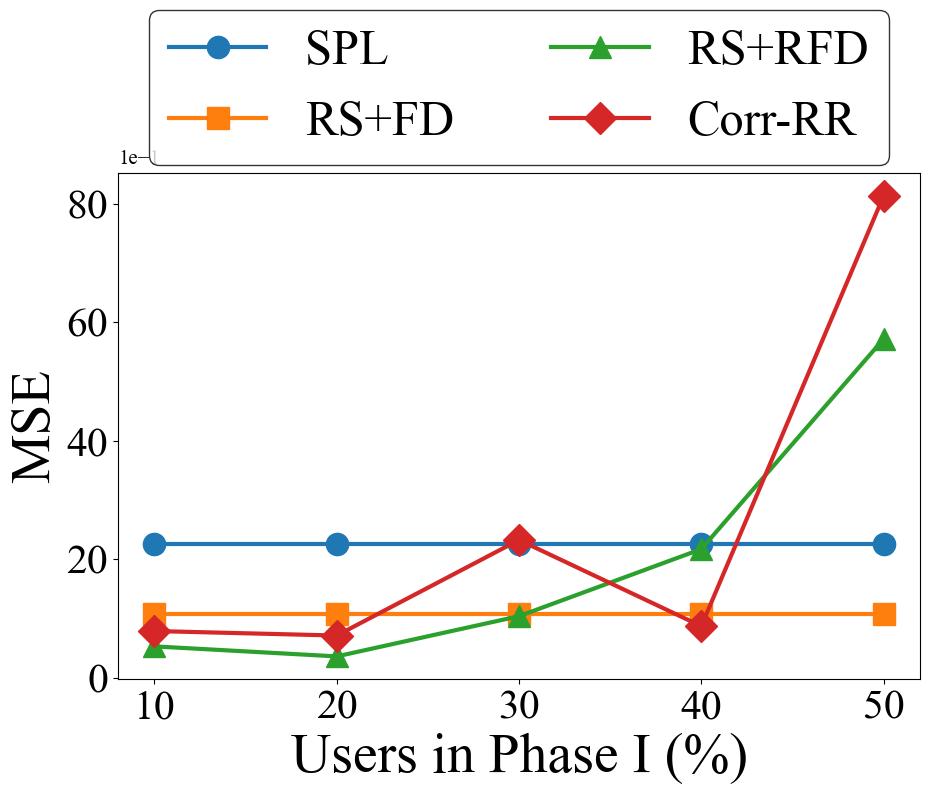

In [8]:
means_star = sweep_vs_phase1_star(
    phase1_pcts=[10,20,30,40,50],
    epsilon=0.1,
    n=2000,
    R=10,
    rho=0.9,
    d=2,
    domain=[0,1,2,3],
    seed=42,
    print_debug=False
)


In [16]:
def print_mse_table(phase1_pcts, means):
    """Pretty 2×K table: RS+RFD and Corr-RR across splits."""
    headers = ["Method"] + [f"{p}%" for p in phase1_pcts]
    rows = []

    # Build RS+RFD row
    row_rs = ["RS+RFD"] + [f"{means['RS+RFD'][i]:.3e}" for i in range(len(phase1_pcts))]
    rows.append(row_rs)

    # Build Corr-RR row
    if "Corr-RR" in means:
        row_corr = ["Corr-RR"] + [f"{means['Corr-RR'][i]:.3e}" for i in range(len(phase1_pcts))]
        rows.append(row_corr)

    # Print table
    col_widths = [max(len(str(row[c])) for row in rows + [headers]) + 2
                  for c in range(len(headers))]

    # Header
    header_line = "".join(str(headers[i]).ljust(col_widths[i]) for i in range(len(headers)))
    print("\n" + header_line)
    print("-" * sum(col_widths))

    # Rows
    for row in rows:
        line = "".join(str(row[i]).ljust(col_widths[i]) for i in range(len(headers)))
        print(line)
    print()
def sweep_vs_phase1_star_table(
    phase1_pcts=(10, 20, 30, 40, 50),
    epsilon=0.6,
    n=10000,
    R=50,
    rho=0.9,
    d=4,
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    seed=None,
    use_corr_rr=True,
    plot_dir=None,
    csv_dir=None,
    print_debug=False,
):
    """Compute MSE table for STAR model (RS+RFD & Corr-RR only)."""

    if domain is None:
        domain = [0, 1]
    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(phase1_pcts)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    # ✅ Fixed STAR dataset
    df = gen_star_from_x1(
        n=n,
        domain=domain,
        d=d,
        x1_marginal=x1_marginal,
        rho=rho,
        q_marginal=q_marginal,
        seed=seed,
    )

    true_freqs = get_true_frequencies(df)

    # ------------------------------------------------------------
    # ✅ Compute RS+RFD and Corr-RR only
    # ------------------------------------------------------------
    for idx, pct in enumerate(phase1_pcts):
        p_frac = pct / 100

        for run in range(R):

            # ---------- RS+RFD ----------
            est_I1, df_B1, dom1 = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
            n1, n2 = len(df) - len(df_B1), len(df_B1)

            priors = est_I1
            pert2 = rs_rfd_perturb(df_B1, dom1, priors, epsilon)
            est_II = rs_rfd_estimate(pert2, dom1, priors, epsilon)

            comb1 = combine_phase_estimates(est_I1, est_II, n1, n2)
            means["RS+RFD"][idx] += np.mean(
                [compute_mse(true_freqs[c], comb1[c]) for c in df.columns]
            )

            # ---------- Corr-RR ----------
            if use_corr_rr:

                est_I2, df_B2, dom2 = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
                n1c, n2c = len(df) - len(df_B2), len(df_B2)

                p_y_table = build_p_y_table(est_I2, n2c, dom2, epsilon)

                pert_corr = corr_rr_phase2_perturb(df_B2, epsilon, est_I2, dom2, p_y_table)
                est_IIc = corr_rr_estimate(pert_corr, dom2, epsilon)

                comb2 = combine_phase_estimates(est_I2, est_IIc, n1c, n2c)
                means["Corr-RR"][idx] += np.mean(
                    [compute_mse(true_freqs[c], comb2[c]) for c in df.columns]
                )

        means["RS+RFD"][idx] /= R
        if use_corr_rr:
            means["Corr-RR"][idx] /= R

    # ✅ Pretty 2×K table
    print("\n================ MSE TABLE (STAR MODEL) ================")
    print_mse_table(phase1_pcts, means)

    return means
def sweep_vs_phase1_progressive_table(
    phase1_pcts=(10, 20, 30, 40, 50),
    epsilon=0.6,
    n=10000,
    R=50,
    rho=0.9,
    d=4,
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    seed=None,
    use_corr_rr=True,
    plot_dir=None,
    csv_dir=None,
    print_debug=False,
):
    """Compute MSE table for PROGRESSIVE model (RS+RFD & Corr-RR only)."""

    if domain is None:
        domain = [0, 1]
    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(phase1_pcts)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    # ✅ One progressive dataset
    df = gen_progressive(
        n=n,
        domain=domain,
        d=d,
        x1_marginal=x1_marginal,
        rho=rho,
        q_marginal=q_marginal,
        seed=seed,
    )

    true_freqs = get_true_frequencies(df)

    # ------------------------------------------------------------
    # ✅ Compute only RS+RFD and Corr-RR
    # ------------------------------------------------------------
    for idx, pct in enumerate(phase1_pcts):
        p_frac = pct / 100

        for run in range(R):

            # RS+RFD
            est_I1, df_B1, dom1 = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
            n1, n2 = len(df) - len(df_B1), len(df_B1)

            priors = est_I1
            pert2 = rs_rfd_perturb(df_B1, dom1, priors, epsilon)
            est_II = rs_rfd_estimate(pert2, dom1, priors, epsilon)

            comb1 = combine_phase_estimates(est_I1, est_II, n1, n2)
            means["RS+RFD"][idx] += np.mean(
                [compute_mse(true_freqs[c], comb1[c]) for c in df.columns]
            )

            # Corr-RR
            if use_corr_rr:
                est_I2, df_B2, dom2 = corr_rr_phase1_spl(df, epsilon, frac=p_frac)
                n1c, n2c = len(df) - len(df_B2), len(df_B2)

                p_y_table = build_p_y_table(est_I2, n2c, dom2, epsilon)
                pert_corr = corr_rr_phase2_perturb(df_B2, epsilon, est_I2, dom2, p_y_table)
                est_IIc = corr_rr_estimate(pert_corr, dom2, epsilon)

                comb2 = combine_phase_estimates(est_I2, est_IIc, n1c, n2c)
                means["Corr-RR"][idx] += np.mean(
                    [compute_mse(true_freqs[c], comb2[c]) for c in df.columns]
                )

        means["RS+RFD"][idx] /= R
        if use_corr_rr:
            means["Corr-RR"][idx] /= R

    # ✅ Pretty table
    print("\n=============== MSE TABLE (PROGRESSIVE MODEL) ===============")
    print_mse_table(phase1_pcts, means)

    return means


In [25]:
means_star = sweep_vs_phase1_star_table(
    phase1_pcts=[10, 20],
    epsilon=0.1,
    n=2000,
    domain=[0,1,2,3],
    R=10,
    rho=0.9,
    d=2,
    seed=42
)



================ MSE TABLE (STAR MODEL) ================

Method   10%        20%        
-------------------------------
RS+RFD   1.132e-01  1.729e-01  
Corr-RR  1.414e-01  1.912e-01  



In [28]:
means_star = sweep_vs_phase1_star_table(
    phase1_pcts=[10, 20],
    epsilon=0.1,
    n=2000,
    domain=[0,1,2,3],
    R=10,
    rho=0.1,
    d=2,
    seed=42
)



================ MSE TABLE (STAR MODEL) ================

Method   10%        20%        
-------------------------------
RS+RFD   1.462e-01  1.618e-01  
Corr-RR  1.704e-01  2.342e-01  



In [27]:


means_star = sweep_vs_phase1_progressive_table(
    phase1_pcts=[10, 20],
    epsilon=0.1,
    n=2000,
    domain=[0,1,2,3],
    R=10,
    rho=0.9,
    d=2,
    seed=42
)


=============== MSE TABLE (PROGRESSIVE MODEL) ===============

Method   10%        20%        
-------------------------------
RS+RFD   1.250e-01  1.444e-01  
Corr-RR  1.508e-01  1.953e-01  

